# Titanic: Machine Learning from Disaster
© Luis E Arribas - Computer science engineer

### Challenge description:

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Data Dictionary

- Survival: _0 = No, 1 = Yes_
- pclass: _Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd_ 
- sex: _Sex_ 
- Age:  _Age in years_ 
- sibsp: # _of siblings / spouses aboard the Titanic_ 
- parch: # _of parents / children aboard the Titanic_ 
- ticket: _Ticket number_ 
- fare: _Passenger fare_ 
- cabin: _Cabin number_ 
- embarked: _Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton_

Variable Notes

- pclass: *A proxy for socio-economic status (SES)
_1st = Upper
2nd = Middle
3rd = Lower*

- age: *Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5*

- sibsp: The dataset defines family relations in this way...
_Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)_

- parch: The dataset defines family relations in this way...
_Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them._

## Exploration Data Analisys



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, KFold, cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print('train data shape: ')
print(train_data.shape)
print('**************')
print('train data description: ')
print(train_data.describe())
print('**************')
print('train data head: ')
print(train_data.head())
print('**************')
print('train data fetures: ')
print(train_data.columns)
print('**************')
print('train data data types: ')
print(train_data.dtypes)

train data shape: 
(891, 12)
**************
train data description: 
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
************

### Formating data
We´ll use _PassengerId_ as index and select the ground truth column for our training set ('Survived')  

In [3]:
#We´ll use PassengerId as index
train_data=train_data.set_index("PassengerId")
test_data=test_data.set_index("PassengerId")
ground_truth = train_data['Survived']



### Correlation matrix
Now, we will plot a correlation matrix among numerical feautures in order to detect correlations.

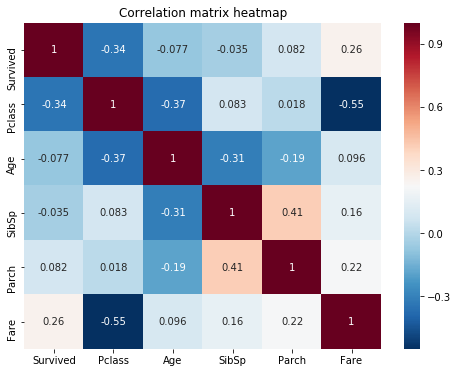

In [4]:
#Check correlation among numerical features
corr = train_data.corr()

fig = plt.figure(figsize=(8,6))
g=sns.heatmap(data= corr, annot=True, cmap='RdBu_r')
plt.title('Correlation matrix heatmap', fontdict=None, loc='center', pad=None)
plt.show()

From the correlation matrix we can do some inferences about the data:

- Pclass - Age: theres a very strong negative relationship between this two features, since the lower the class, the younger the passengers.
- Pclass - Survived: theres a strong negative relationship between this two features. 
- Pclass - Fare: the lower the class (3) the lower the fares.
- Age: looks like there´s no actual relationship between Age and survival possibilities, but this doen not mean the same for some subpopulations (by now we caould think that childresn could have more chances than other people).
- Fare: there´s some relationship between this feature and survival probabilities. This is not a strong correlation though, some subpopulations could see their survival chances heavily correlated with fare. 
- SibSp - Parch: theres no relation between theese two features and survival probvabilities. Anyway, we should check whether theese two features could be usefull for engeneering new ones.


### Inspecting relationships between features and survival probabilities
By now, before any other transformation, we´ll focus on the numeric features that are the most correlated. 

In [5]:
#Drop all columns but one 
target_corr=corr['Survived']
#Transform negative correlation to positive
target_corr.loc[target_corr < 0]=target_corr.loc[target_corr <0]*(-1)
target_corr=target_corr.sort_values(ascending=False)
target_corr

Survived    1.000000
Pclass      0.338481
Fare        0.257307
Parch       0.081629
Age         0.077221
SibSp       0.035322
Name: Survived, dtype: float64

There are some object data type features that could be related with the survival chances of a passenger:

- Name: aparently useless. The passengers are roled in the ship with a title tha could be useful for further inferences, like age or sex, in the case of missing values.
- Ticket: aparently useless feature.
- Sex and Embarked:lets plot some barplots to see if theese two features are relevant. If so, we should use the to define subpopulations.



#### Sex
Lets inspect how survival probabilities are distributed by sex.

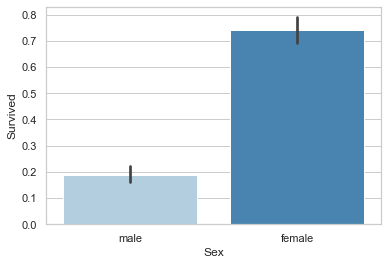

,Survived
Sex,
female,0.742038
male,0.188908


In [6]:
#Plot a barplot
sns.set(style="whitegrid")
sns.despine()
g=sns.barplot(x="Sex",  y='Survived', data=train_data, palette="Blues")
plt.show()
#show in a table
train_data[['Sex','Survived']].groupby('Sex', as_index= True).mean()


#### Pclass and sex
Lets inspect how survival probabilities are distributed by pclass and sex

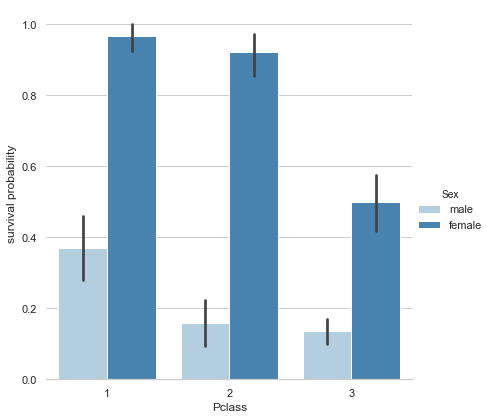

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [7]:
#Plot a barplot
sns.set(style="whitegrid")
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_data, height=6,
                kind="bar", palette="Blues")
g.despine(left=True)
g.set_ylabels("survival probability")
plt.show()

#Show in a table
train_data[['Pclass','Survived','Sex']].groupby(['Pclass','Sex'], as_index= True).mean()

1st and 2nd class women are over 90% survival probabilities. The 3rd class women chances are remarkably under the other classes (about 50%). Beeing a man is not a good business onboard, since less than 20% of them survived on 2nd and 3rd class. Althoug 1st class men double the other classes ones survival probabilities, they are still under 40%.

### Embarked
We will group data by this feature to see if the embarkation port has any influence. If so, there must be different survival ratio for the same sex and class passengers

In [8]:
#Embarked vs survived
train_data[['Embarked','Survived','Sex','Pclass']].groupby(['Embarked','Sex','Pclass'], as_index= True).mean()

Survived
Embarked Sex    Pclass          
C        female 1       0.976744
                2       1.000000
                3       0.652174
         male   1       0.404762
                2       0.200000
                3       0.232558
Q        female 1       1.000000
                2       1.000000
                3       0.727273
         male   1       0.000000
                2       0.000000
                3       0.076923
S        female 1       0.958333
                2       0.910448
                3       0.375000
         male   1       0.354430
                2       0.154639
                3       0.128302

After this grouping operation we can see the following diferences based on the embarkation feature:

- Female 3rd class passengers embarked at S have significantly less survival probabilities than the same class passengers embarked in other ports.
- Male 3rd class  embarked at Q have near 0 survival chances, not like the same class pasengers embarked in other ports.
- 1st and 2nd class male embarked at Q have no survival chance. We must check if any man was embarked there...


In [9]:
train_data[['Embarked','Sex','Pclass']].groupby(['Embarked','Pclass'], as_index= True).Sex.count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Sex, dtype: int64

Just 5 men embarked in class 1 and 2 at Q, so we can not make any inference about the data, since the sample is too small. Summing up, ther could be some point on making subpopulations with S and Q ports

### Fare


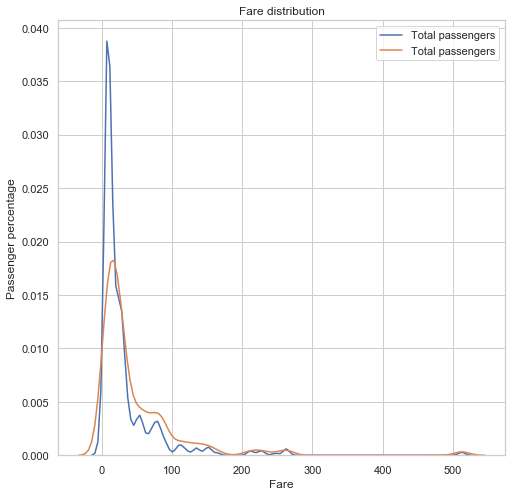

In [10]:
fig = plt.figure(figsize=(8,8))
p1=sns.distplot(train_data['Fare'].dropna().values,  hist=False, label='Total passengers')
p2=sns.distplot(train_data['Fare'].dropna().loc[train_data['Survived'] == True].values,  hist=False, label='Total passengers')


plt.xlabel('Fare')
plt.ylabel('Passenger percentage')
plt.title('Fare distribution', fontdict=None, loc='center', pad=None)
plt.show()

Seems to be a clear tendence to death on lowest fare passengers. Theres a crossing point about 30. This could lead us to categorization of the feature in two bins

### Parch
We know that theres no linear relationship between this feature and Survived. Firstly we´ll inspect how theese values are distributed

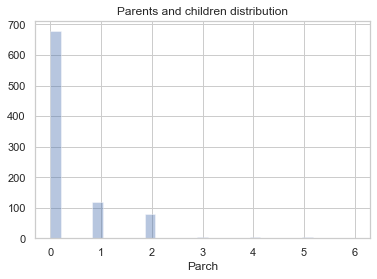

Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


In [11]:
p1=sns.distplot(train_data['Parch'], kde = False)
plt.title('Parents and children distribution')
plt.show()
pd.crosstab(train_data['Parch'],train_data['Survived'] )

Seems like passengers with no parents or children on board has considerably less oportunities of surviving than the rest. As we mentioned befere this could be a tip for defining a new subpulation. Lets see the SibSP feature now:

### SibSp
We will treat this feature as the previous one, in rder to see if we could extract any insight.

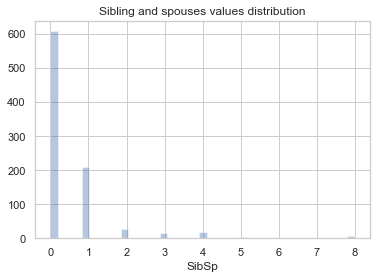

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


In [12]:
p1=sns.distplot(train_data['SibSp'], kde = False)
plt.title('Sibling and spouses values distribution')
plt.show()
pd.crosstab(train_data['SibSp'],train_data['Survived'] )

Again, a 0 value means less survival probabilities than any other value. For the highest values the sample is too short to make any inference.

### Age
Firstly, we plot the distributions of the total populations Age over the survivors Age, in order to see if they match or there is any remarkable discovery

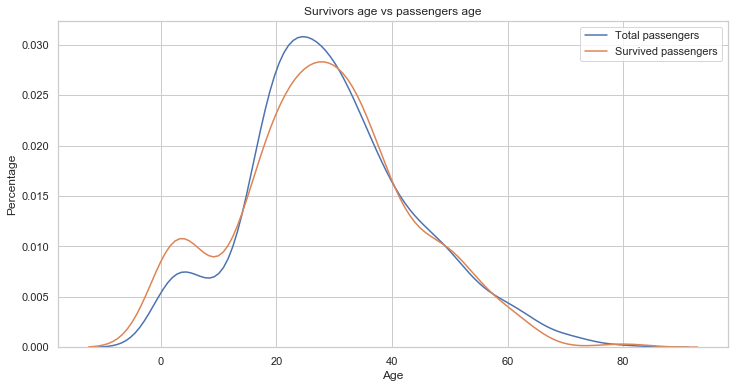

In [13]:
fig = plt.figure(figsize=(12,6))
p1=sns.distplot(train_data['Age'].dropna().values,  hist=False, label='Total passengers', kde=True)
p2=sns.distplot(train_data['Age'].loc[train_data['Survived']==1].dropna().values,
                hist=False,label='Survived passengers')
plt.ylabel('Passengers percentage')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Survivors age vs passengers age', fontdict=None, loc='center', pad=None)
plt.show()

There are three possible bins or areas in this feature values. They are defined by the intersection of the two plots. Thus, the first one goes from 0 to 16 year, the second one goes from 16 to 33, the third goes from 58 to max value. According to this, the survivors percentage in the first area is higher than the population percentage. In the second area it goes on the oposite way. The third area makes no difference and the fourth one lowers the survival chances of older people.

Let´s take a look over the survivor ages by class:

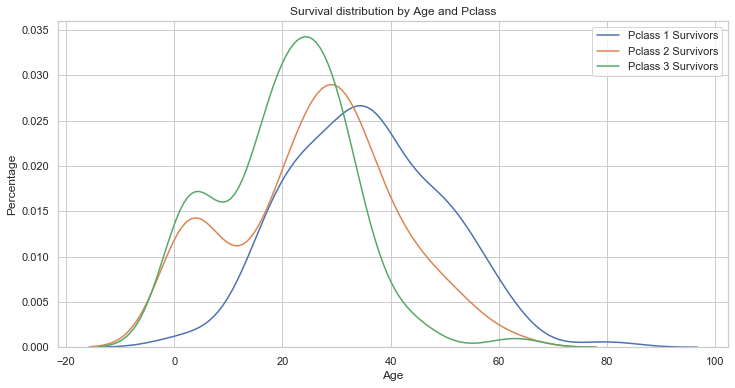

In [14]:
#Edad vs survival by class
fig = plt.figure(figsize=(12,6))
#p1=sns.distplot(train_data['Age'].dropna().values,  hist=False, label='Total passengers')
p2=sns.distplot(train_data['Age'].loc[train_data['Survived']==1].loc[train_data['Pclass']==1].dropna().values,
                hist=False,label='Pclass 1 Survivors')
p3=sns.distplot(train_data['Age'].loc[train_data['Survived']==1].loc[train_data['Pclass']==2].dropna().values,
                hist=False,label='Pclass 2 Survivors')
p4=sns.distplot(train_data['Age'].loc[train_data['Survived']==1].loc[train_data['Pclass']==3].dropna().values,
                hist=False,label='Pclass 3 Survivors')
plt.ylabel('Passengers percentage')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Survival distribution by Age and Pclass', fontdict=None, loc='center', pad=None)
plt.show()

As we can see, the survivor age distribution in 1st class is clearly different to the other two, but so it is with the total population age by Pclass

## Feature engineering

The first step of this phase is to combien both train and test data splitting ground thruth values. Afterwards we´ll look for missing values.

In [15]:
y=train_data['Survived']
combined_data=train_data.drop(['Survived'], axis=1)
combined_data=pd.concat([combined_data, test_data])
print(f'Data shape is {combined_data.shape[0]} rows and {combined_data.shape[1]} columns')
print(f'There are {combined_data.isna().sum().sum()} missing values')
print('-----------------------------')
print(combined_data.isna().sum())

Data shape is 1309 rows and 10 columns
There are 1280 missing values
-----------------------------
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64


### Cabin
Cabin seems to be a useless feature, so we´ll drop it

In [16]:
combined_data.drop(['Cabin'], axis = 1, inplace = True)

### Embarked

There are two null values. Firstly we´ll take a look over them. 

In [17]:
combined_data.loc[combined_data['Embarked'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Two females, with a 80 Fare paid in 1st class. We may impute the embarkation port using the closest mean fare for 1st class

In [18]:
print('mean fare values by port and class')
print('----------------------------------')
print(combined_data[['Fare','Pclass', 'Embarked']].groupby(['Pclass', 'Embarked']).Fare.mean())

mean fare values by port and class
----------------------------------
Pclass  Embarked
1       C           106.845330
        Q            90.000000
        S            72.148094
2       C            23.300593
        Q            11.735114
        S            21.206921
3       C            11.021624
        Q            10.390820
        S            14.435422
Name: Fare, dtype: float64


Following this criteria the most probable value is Southamptom. On the other hand, we can impute this values using the most common port for 1st class

In [19]:
print('Number of embarkations by port and class')
print('----------------------------------')
print(combined_data[['Fare','Pclass', 'Embarked']].groupby(['Pclass', 'Embarked']).Fare.count())

Number of embarkations by port and class
----------------------------------
Pclass  Embarked
1       C           141
        Q             3
        S           177
2       C            28
        Q             7
        S           242
3       C           101
        Q           113
        S           494
Name: Fare, dtype: int64


In this case the most common port is Southampton too, so we impute this value with no further action.

In [20]:
combined_data.fillna({'Embarked': 'C'}, inplace = True)

### Fare

As we have seen before there is just one missing value. As a first step we will impute it with the matching class and  embarkation port fare

In [21]:
print(f'\nmin fare paid: {combined_data.loc[combined_data.Fare>0].Fare.min()} ')
print(f'max fare paid: {combined_data.Fare.max()} ')
print(f'Passengers with free tickets: {combined_data.loc[combined_data.Fare==0].Name.count()}')
print('\nMean fares paid per Embarkation port and class')
print('----------------------------------------------')
print(combined_data.groupby(['Embarked','Pclass']).Fare.mean())
combined_data.loc[combined_data['Fare'].isna()]


min fare paid: 3.1708 
max fare paid: 512.3292 
Passengers with free tickets: 17

Mean fares paid per Embarkation port and class
----------------------------------------------
Embarked  Pclass
C         1         106.469871
          2          23.300593
          3          11.021624
Q         1          90.000000
          2          11.735114
          3          10.390820
S         1          72.148094
          2          21.206921
          3          14.435422
Name: Fare, dtype: float64


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [22]:
combined_data['Fare']=combined_data['Fare'].fillna(combined_data.groupby(['Embarked','Pclass'])['Fare'].transform('mean'))

In [23]:
data = combined_data[['Fare','Embarked','Pclass']].groupby(['Embarked', 'Pclass']).Fare.mean().sort_values(axis = 0)
print(data)
print(f'\nmin fare paid: {combined_data.loc[combined_data.Fare>0].Fare.min()} ')
print(f'max fare paid: {combined_data.Fare.max()} ')
print(f'Passengers with free tickets: {combined_data.loc[combined_data.Fare==0].Name.count()}')

Embarked  Pclass
Q         3          10.390820
C         3          11.021624
Q         2          11.735114
S         3          14.435422
          2          21.206921
C         2          23.300593
S         1          72.148094
Q         1          90.000000
C         1         106.469871
Name: Fare, dtype: float64

min fare paid: 3.1708 
max fare paid: 512.3292 
Passengers with free tickets: 17


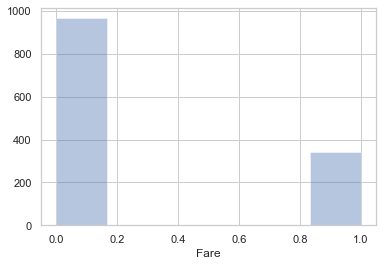

In [24]:
bins = [0,30, combined_data.Fare.max()]
labels = range(0, 2)
combined_data.Fare = pd.cut(combined_data.Fare, bins, labels = labels)
combined_data.Fare.fillna(0, inplace = True)
combined_data.Fare = combined_data.Fare.astype('int8')
p1=sns.distplot(combined_data['Fare'], kde = False)

### Title
Our purpose is extracting the title of the passenger from the name, in order to obtain the most probably values for missing age.

In [25]:
combined_data['Title'] = combined_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combined_data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
Jonkheer          1
Lady              1
Mme               1
Capt              1
Sir               1
the Countess      1
Don               1
Name: Title, dtype: int64

In [26]:
combined_data['Title'] = combined_data['Title'].replace(['Lady', 'the Countess',
                                                         'Capt', 'Col','Don', 'Dr',
                                                         'Major', 'Rev', 'Sir',
                                                         'Jonkheer', 'Dona'], 'Rare')
combined_data['Title'] = combined_data['Title'].replace('Mlle', 'Miss')
combined_data['Title'] = combined_data['Title'].replace('Ms', 'Miss')
combined_data['Title'] = combined_data['Title'].replace('Mme', 'Mrs')
combined_data.groupby(['Title', 'Sex']).Age.mean()
combined_data.drop('Name', axis=1, inplace=True)

Lets check if any missing age passenger has any other missing feature. As we can see there are just 

In [27]:
combined_data.loc[combined_data['Age'].isna()].count()

Pclass      263
Sex         263
Age           0
SibSp       263
Parch       263
Ticket      263
Fare        263
Embarked    263
Title       263
dtype: int64

In [28]:
combined_data.isna().sum()

Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
Title         0
dtype: int64

### Fill Age null values
Firstly we´ll study the age feature distribution by Pclass. 

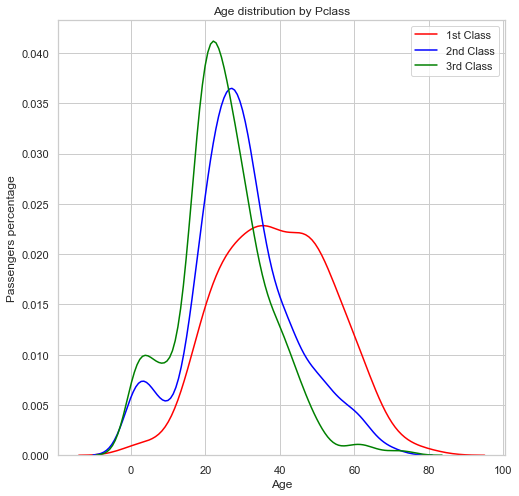

In [29]:
fig = plt.figure(figsize=(8,8))
p1=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==1].values,
                hist=False, color='Red',  label='1st Class')
p2=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==2].values,
                hist=False, color='Blue' ,label='2nd Class')
p3=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==3].values,
                hist=False, color='Green' ,label='3rd Class')

plt.ylabel('Passengers percentage')
plt.xlabel('Age')
plt.title('Age distribution by Pclass', fontdict=None, loc='center', pad=None)
plt.show()

There are some strategies to use here:

- We could fill randomly by class all the missing values, since the three classes follow quite a normaloid distribution. This would make different results for different exuctions of the model.
- We could use the mean age value for each class. 
- We could use the mean age value for the title contained in each name gruped by class and sex. This is the one that we are going to use.

In [30]:
combined_data[['Age', 'Title', 'Pclass', 'Sex']].groupby(['Title', 'Pclass','Sex']).mean()

Age
Title  Pclass Sex              
Master 1      male     6.984000
       2      male     2.757273
       3      male     6.090000
Miss   1      female  30.131148
       2      female  20.865714
       3      female  17.360874
Mr     1      male    41.450758
       2      male    32.346715
       3      male    28.318910
Mrs    1      female  42.926471
       2      female  33.518519
       3      female  32.326531
Rare   1      female  42.250000
              male    49.214286
       2      male    40.700000

In [31]:
combined_data['Age']=combined_data['Age'].fillna(combined_data.groupby(['Title','Pclass','Sex'])['Age'].transform('mean'))
combined_data['Age'].isna().sum()

0

Lets plot the null-filled age distribution. 

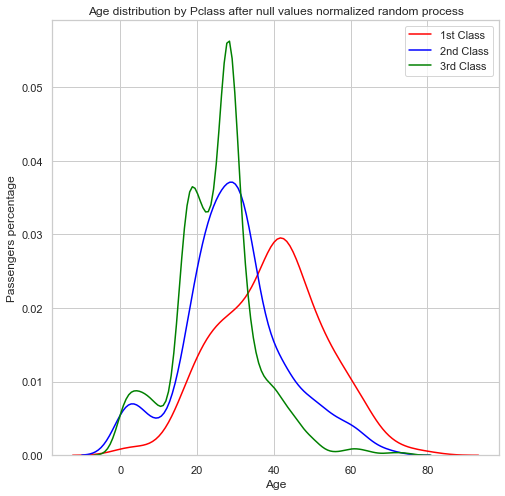

In [32]:
fig = plt.figure(figsize=(8,8))
p1=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==1].values,  hist=False, color='Red',
                label='1st Class')
p2=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==2].values,  hist=False, color='Blue'
                ,label='2nd Class')
p3=sns.distplot(combined_data['Age'].loc[combined_data['Pclass']==3].values,  hist=False, color='Green'
                ,label='3rd Class')
plt.ylabel('Passengers percentage')
plt.xlabel('Age')
plt.title('Age distribution by Pclass after null values normalized random process', fontdict=None,
          loc='center', pad=None)
plt.show()

The distribution shape is quite different now, but it should not matter since we are going to cut this numerical atribute in 4 bins at 16, 33 and 58.

1    765
2    359
0    142
3     43
Name: Age, dtype: int64


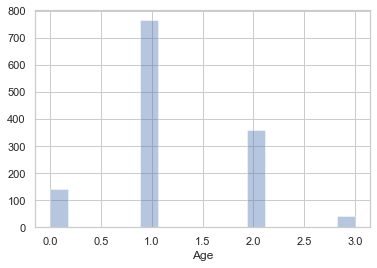

In [33]:
bins = [0,16,33,58, combined_data['Age'].max().astype('int8')]
labels = range(0, 4)
#labels = ['Child', 'Young', 'Senior', 'Elder']
combined_data['Age'] = pd.cut(combined_data['Age'], bins, labels = labels)
combined_data.drop(['Title'], axis=1, inplace=True)
combined_data['Age'] = combined_data['Age'].astype('int8')
#combined_data.Age = combined_data.Age.astype('int8')
sns.distplot(combined_data['Age'], kde = False)
print(combined_data['Age'].value_counts())

### Sex. Adding value (Child)
As we´ve seen before, there´s a huge difference in survival probabailities if age is under 16. There is also a remarkable difference between genders. Anyway it seems logical that there´s no diference by gender in children so we´ll create a new gender called "Child". Firstly we´ll check how the class is related to survival probabilities in people under 16.

In [34]:
train_data[[ 'Survived', 'Pclass']].loc[train_data['Age']< 16].groupby('Pclass').mean()

,Survived
Pclass,
1,0.833333
2,1.000000
3,0.431034


In [35]:
combined_data['Sex'].loc[combined_data['Age']== 0]= 'Child'
t = combined_data.join(ground_truth)
t.dropna(inplace = True)

Lets see the results 

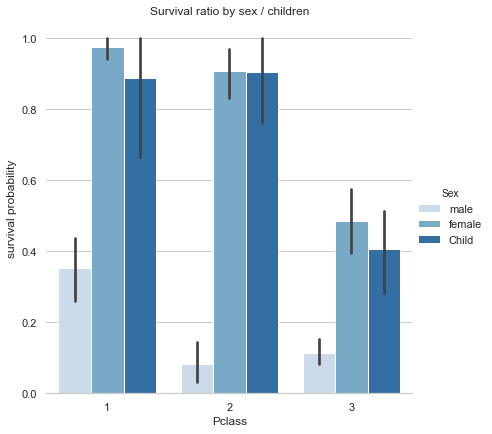


Sex
female    0.754717
Child     0.548077
male      0.162835
Name: Survived, dtype: float64


In [36]:
sns.set(style="whitegrid")
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=t, height=6,
                kind="bar", palette="Blues")
g.despine(left=True)
g.set_ylabels("survival probability ")
plt.title('Survival ratio by sex / children')
plt.show()
t= t.groupby(['Sex']).Survived.mean()
print('')
print(t.nlargest(len(t)))

Now, lets categorize the feature to make it usefull for the further classification stage 

In [37]:
labels = {'female':0, 'Child':1, 'male':2}
combined_data['Sex'].loc[combined_data['Sex']=='female']=0
combined_data['Sex'].loc[combined_data['Sex']=='Child']=1
combined_data['Sex'].loc[combined_data['Sex']=='male']=2
combined_data['Sex'] = combined_data['Sex'].astype('int8')



##
combined_data['Sex'].value_counts()

2    765
0    402
1    142
Name: Sex, dtype: int64

### Relatives
We will define a new feature in order to detect alone passengers. Since we have detected that SibSp and Parch makes the difference just for 0 values, we will sum both features and drop them afterwards.

In [38]:
combined_data['Relatives'] = combined_data['SibSp'] + combined_data['Parch']
combined_data[['Sex','Pclass', 'Relatives']].groupby(['Pclass', 'Sex']).median()
combined_data.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

### Alone passengers
As we have seen before, passengers with 0 values in SibSp and Parch has less survival probabilities. Lets combine theese two features in ordesr to genenerate a new feature for alone passengers. Before doing that, we will make some operations to calcule the survival probabilities of a single alone person.

In [39]:
alone = combined_data.loc[combined_data['Relatives'] == 0]
alone_index =  set(alone.index) & set(train_data.index)
alone = train_data.loc[np.array(list(alone_index))]
alone_survivors = alone.loc[alone['Survived'] == 1]
alone_survivors = combined_data.loc[np.array(list(alone_survivors.index))]
#ratio supervivencia hombres solos
print(f'alone passengers survival rate is {100*len(alone_survivors)/len(alone)}')

alone passengers survival rate is 30.353817504655492


Ok! Looks like its quite representative, so lets do this

In [40]:
def Alone(row):
    if(row['Relatives'] == 0):
        return 1
    else:
        return 0

In [41]:
t=[]
for index, row in combined_data.iterrows(): 
    t.append(Alone(row))
combined_data['Alone']=t
combined_data.drop(['Relatives'], axis=1, inplace = True)


### Hot one encoding features

In [42]:
combined_data=pd.get_dummies(combined_data, columns=['Embarked'])

In [43]:
combined_data.dtypes

Pclass         int64
Sex             int8
Age             int8
Ticket        object
Fare            int8
Alone          int64
Embarked_C     uint8
Embarked_Q     uint8
Embarked_S     uint8
dtype: object

### Drop Ticket feature

In [44]:
combined_data.drop(['Ticket'], axis=1, inplace=True)

### Data split in train, test & ground truth sets 

In [45]:
combined_data = combined_data.join(ground_truth)
train_data=combined_data.iloc[0:len(train_data)]
test_data=combined_data.iloc[len(train_data):len(combined_data)]
test_data.drop('Survived', axis=1 ,inplace = True)
test_data.shape

(418, 8)

### Correlation matrix 

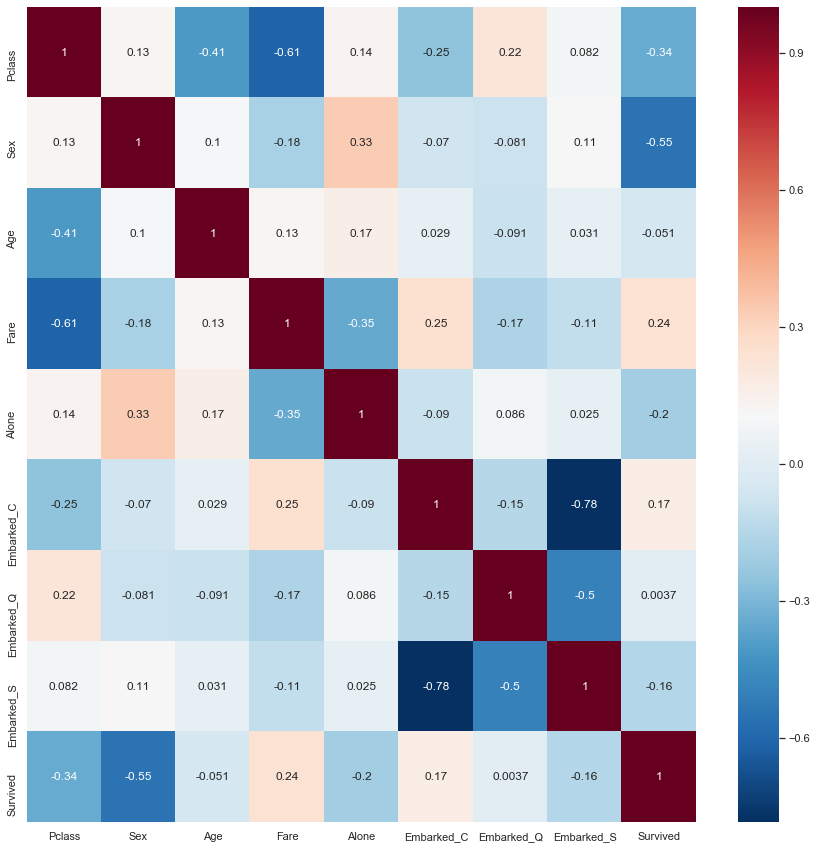

Survived      1.000000
Sex           0.551226
Pclass        0.338481
Fare          0.242191
Alone         0.203367
Embarked_C    0.174718
Embarked_S    0.155660
Age           0.051360
Embarked_Q    0.003650
Name: Survived, dtype: float64


In [46]:
#Plot correlation heatmap
corr = train_data.corr()
fig = plt.figure(figsize=(15,15))
g=sns.heatmap(data= corr, annot=True, cmap='RdBu_r')
plt.show()

#Check features correlation  
target_corr=corr['Survived']
#Transform negative corr to pos
target_corr.loc[target_corr < 0]=target_corr.loc[target_corr <0]*(-1)
target_corr=target_corr.sort_values(ascending=False)
#Print sorted feature list
print(target_corr)

In [47]:
columns_to_drop = target_corr.index.where(target_corr<0.15).dropna()
train_data.drop(columns_to_drop, axis = 1, inplace = True)
test_data.drop(columns_to_drop, axis = 1, inplace = True)

## Modeling topics


### Base probabilities

- All dead prediction
- Gender based prediction

### Base models

- Random forests
- Support Vector Machines
- kNN
- Deep learning
- Gradient boosting
- X gradient boosting

### Ensemble model

- Voting classifier



## Classification
Import modules and split data

In [48]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Survived',axis=1),train_data.Survived,test_size=0.30, random_state=34)

### Base probabilities

#### All dead prediction
Asumming that everybody dies onboard, the model accuracy is:

In [49]:
t=X_train.copy()
t['Pred']=0
print('Asumming that everybody dies accuracy is: %.5f ' % (accuracy_score(y_train, t.Pred)))

Asumming that everybody dies accuracy is: 0.61156 


#### Gender based probabilities
Asuming that all male die, and all female survive the base probabilities, equivalent to a flip coin method are:

In [50]:
p=[]
t=X_train.copy()
for row in t.iterrows():
    if row[1].Sex != 2:
        p.append(1)
    else:
        p.append(0)
        
t['Pred']=p
#X_train
print('Asumming that all male die accuracy is: %.5f ' % (accuracy_score(y_train, t.Pred)))


Asumming that all male die accuracy is: 0.77368 


So, this is the starting point. Our model must improve this accuracy.

### Base classification models

In [51]:
#Random Forest model hyperparameter search
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
print(cross_val_score(rf_clf, X_train, y_train, cv=5).mean())

0.7833611879160266


In [52]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
print(cross_val_score(tree_clf, X_train, y_train, cv=5).mean())

0.7736837685611879


In [53]:
from sklearn import svm
svm_clf = svm.SVC(probability = True)
svm_clf.fit(X_train, y_train)
print(cross_val_score(svm_clf, X_train, y_train, cv=5).mean())

0.7913620071684588


In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
print(cross_val_score(knn_clf, X_train, y_train, cv=5).mean())

0.775194470046083


In [55]:
from  sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
print(cross_val_score(gb_clf, X_train, y_train, cv=5).mean())

0.7848974910394266


In [56]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
print(cross_val_score(xgb_clf, X_train, y_train, cv=5).mean())

0.7864591909882233


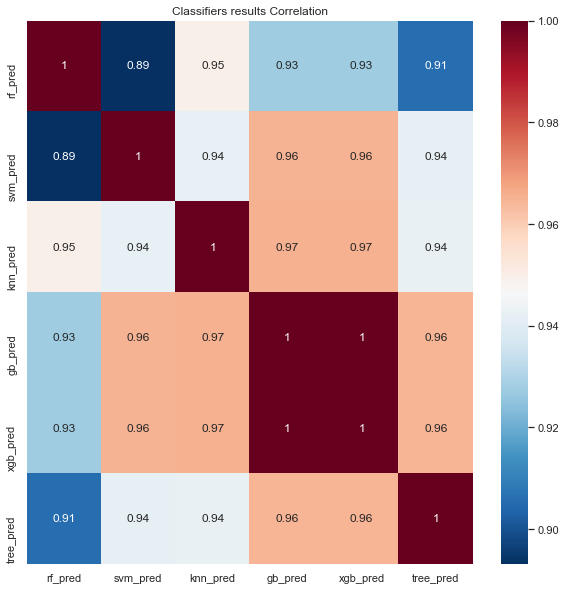

In [57]:
#Base models predictions
rf_pred = rf_clf.predict(test_data)
svm_pred = svm_clf.predict(test_data)
knn_pred = knn_clf.predict(test_data)
gb_pred = gb_clf.predict(test_data)
xgb_pred = xgb_clf.predict(test_data)
tree_pred = tree_clf.predict(test_data)
predictions = [rf_pred, svm_pred, knn_pred, gb_pred, xgb_pred, tree_pred]
results_corr_matrix = np.zeros((len(rf_pred), len(predictions)), dtype=int)

i=0
for p in predictions:        
        results_corr_matrix[:,i] = p
        i+=1

results_corr_matrix = pd.DataFrame(results_corr_matrix)
results_corr_matrix = results_corr_matrix.rename(columns = {0:'rf_pred', 
                                                            1:'svm_pred', 
                                                            2:'knn_pred', 
                                                            3: 'gb_pred', 
                                                            4: 'xgb_pred',
                                                            5: 'tree_pred'})

corr = results_corr_matrix.corr()
fig = plt.figure(figsize = (10,10))
g = sns.heatmap(data = corr, annot=True, cmap='RdBu_r')
plt.title('Classifiers results Correlation')
plt.show()

close to one correlations might not be a good choice for ensembling. For the voting ensemble we will choose random forest, svm and knn since they are the less correlated.

In [58]:
#Voting ensemble
from sklearn.ensemble import VotingClassifier

#knn 
eclf1 = VotingClassifier(estimators=[
        #('gb', gb_clf), 
        ('rf', rf_clf), 
        ('svm', svm_clf), 
        ('xgb', xgb_clf), 
        #('tree', tree_clf), 
        ('knn', knn_clf)
        ],
        voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
print(cross_val_score(eclf1, X_train, y_train, cv=5).mean())


#Voting ensemble prediction 
ensemble_pred=eclf1.predict(test_data)
ensemble_pred=ensemble_pred.astype(int)

0.8009495135688685


### Submission

In [59]:
pred = ensemble_pred

def make_submission():
    submission=pd.DataFrame(pred)
    submission[1]=submission[0]
    submission[0]=test_data.index
    submission = submission.rename(columns = {0: 'PassengerId', 1:'Survived'})
    submission.to_csv("submission.csv", index=False)
    return submission.head()

make_submission()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


Our best performance is 0.80740 on train data, which means a 3,372% improvement against gender model (0.77368). It scored 0.78468 in Public LB @Kaggle. 

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

https://www.kaggle.com/kpacocha/top-6-titanic-machine-learning-from-disaster

https://www.kaggle.com/toldo171/titanic-a-beginner-guide-to-top-6

https://www.kaggle.com/ankush87/titanic-top-8-with-xgboost

https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688

